# Agnostic Person Generation

This notebook provides a utility to generate "Agnostic Person" images and parsing maps. 
An agnostic person is a representation where the original garment and arms are removed (replaced by a gray area). 
The gray area is slightly larger than the original garment to break the **Cloth Shape Bias**, ensuring the flow renderer doesn't confine the new garment to the mask of the old one.

In [17]:
import os
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# LIP Labels Mapping
# Labels to MASK OUT (Gray area):
# 5: Upper-clothes, 6: Dress, 7: Coat, 14: Left-arm, 15: Right-arm
AGNOSTIC_LABELS = [5, 6, 7, 14, 15]

# Labels to PRESERVE (Keep original pixels even if mask overlaps):
# 1: Hat, 2: Hair, 4: Sunglasses, 13: Face
PRESERVE_LABELS = [1, 2, 4, 13]

## Agnostic Generation Function

In [18]:
def get_agnostic_person(img_path, parse_path, dilation_kernel_size=25):
    """
    Generates agnostic image and parsing map with feature preservation.
    """
    # Load image and parsing
    image = np.array(Image.open(Path(img_path)).convert("RGB"))
    parse = np.array(Image.open(Path(parse_path)))

    # 1. Create preservation mask (Parts of the person we want to keep at all costs)
    preserve_mask = np.isin(parse, PRESERVE_LABELS).astype(np.uint8)

    # 2. Create binary mask for agnostic areas (Clothes and Arms)
    agnostic_mask = np.isin(parse, AGNOSTIC_LABELS).astype(np.uint8)

    # 3. Dilate the agnostic mask to break 'Cloth Shape Bias'
    kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    dilated_mask = cv2.dilate(agnostic_mask, kernel, iterations=1)

    # 4. Refine Dilated Mask: Subtract the preservation mask
    # This ensures gray area doesn't cover hair, face, or hat
    final_agnostic_mask = (dilated_mask == 1) & (preserve_mask == 0)

    # Create Agnostic Image
    agnostic_img = image.copy()
    # Replace masked area with neutral gray (128, 128, 128)
    agnostic_img[final_agnostic_mask] = [128, 128, 128]
    
    # Create Agnostic Parsing
    # We clear the garment/arm labels from the parsing map
    agnostic_parse = parse.copy()
    agnostic_parse[agnostic_mask == 1] = 0 # Set to background

    return Image.fromarray(agnostic_img), Image.fromarray(agnostic_parse)

## Visualization / Test

Processing: 00005_00.jpg


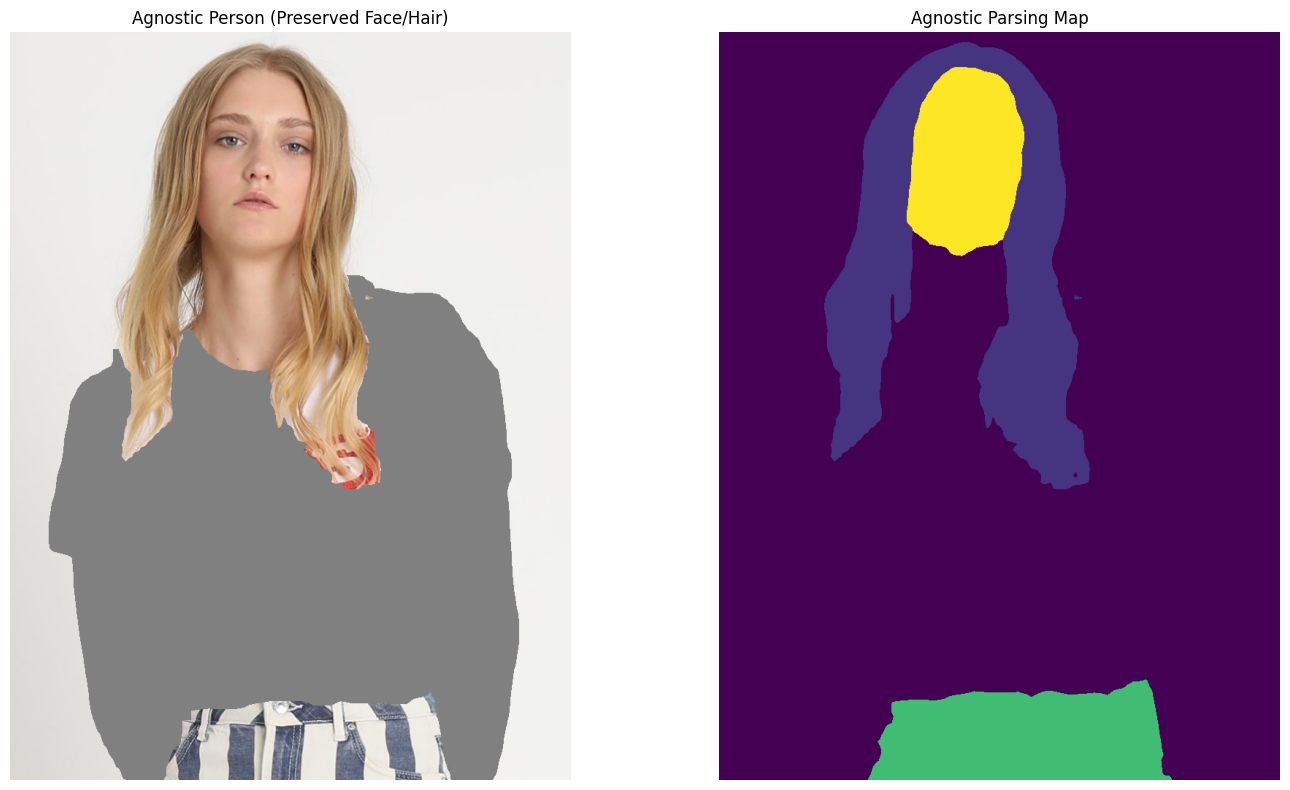

In [23]:
person_id = "00005_00"

# RECOMMENDED: Auto-detect project root directory
current_dir = Path.cwd()
if (current_dir / "data").exists():
    root_dir = current_dir
elif (current_dir.parent / "data").exists():
    root_dir = current_dir.parent
else:
    # Fallback to absolute drive paths if detection fails
    root_dir = Path("/content/drive/MyDrive/virtual_tryon_project")

img_file = root_dir / "data/viton_hd/train/image" / f"{person_id}.jpg"
parse_file = root_dir / "Self-Correction-Human-Parsing/demo_output" / f"{person_id}.png"

if not img_file.exists():
    print(f"ERROR: Image file not found at {img_file.absolute()}")
if not parse_file.exists():
    print(f"ERROR: Parsing file not found at {parse_file.absolute()}")

if img_file.exists() and parse_file.exists():
    print(f"Processing: {img_file.name}")
    agn_img, agn_prse = get_agnostic_person(img_file, parse_file)

    # Visualize results
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].imshow(agn_img)
    axes[0].set_title("Agnostic Person (Preserved Face/Hair)")
    axes[0].axis('off')

    axes[1].imshow(agn_prse)
    axes[1].set_title("Agnostic Parsing Map")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()